## Imports

In [2170]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#from aleialib.s3 import load_file

In [2171]:
df = pd.read_csv('Data_Finance_TrainEtVal_13Nov23.csv', sep=';')
df.shape

(18516, 43)

## Visualisation de nos données

In [2172]:
df.head()

,Id,GENR,produit,age du bien,mode de paiement,montant demande (centimes),delai paiement,apport,apport %,date demande,...,impayes,charge,fichage3,revenus,secteur activite,code postal,Chiffre d'affaires,Capital social,Indicatrice,Label
0,4212339,VP,LLD,0,10,4967310,10,0,0.0,04/01/2010 09:59,...,0,0,0,0,77,95100,0,200000,0,Train
1,4212408,VP,CB,0,10,1228763,0,245753,20.0,04/01/2010 10:58,...,0,0,0,100000,41,93600,0,750000,0,Train
2,4212504,VU,CB,0,10,1262250,0,189338,15.0,04/01/2010 12:44,...,0,0,0,100000,43,47130,0,500000,0,Train
3,4212509,,LLD,0,10,1500000,10,0,0.0,04/01/2010 13:19,...,0,0,0,400000,66,67500,0,1000000,0,Train
4,4212561,VU,LLD,0,10,2393850,10,0,0.0,04/01/2010 14:43,...,0,0,0,300000,49,60110,0,750000,0,Train


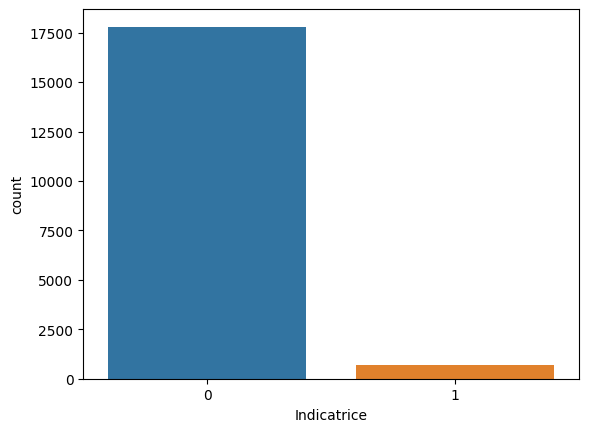

In [2173]:
# repartition of the target variable indicatrice
sns.countplot(x='Indicatrice', data=df)
plt.show()

On remarque un énorme déséquilibre de classes dans notre dataset: plus de 95% des données sont de la classe 0.

In [2174]:
df[df['Label'] == 'Train'].shape

(11804, 43)

In [2175]:
df[df['Label'] == 'Validation'].shape

(6712, 43)

Notre dataset est composé de deux sets de données : un set d'entrainement (11804 entrées) et un set de test (6712 entrées).

In [2176]:
# number of numerical and categorical variables
print('Number of numerical variables: ', len(df.select_dtypes(include=['float64', 'int64']).columns))
print('Number of categorical variables: ', len(df.select_dtypes(include=['object']).columns))

Number of numerical variables:  21
Number of categorical variables:  22


## Data cleaning

In [2177]:
# print columns with missing data
df.isnull().sum()[df.isnull().sum() > 0]

segmentation    1959
dtype: int64

In [2178]:
# pourcentage of 0 value in each column
zero_percentage = (df == 0).mean() * 100
print(zero_percentage)

Id                              0.000000
GENR                            0.000000
produit                         0.000000
age du bien                    91.898898
mode de paiement                0.000000
montant demande (centimes)      0.000000
delai paiement                 72.321236
apport                         59.354072
apport %                       59.354072
date demande                    0.000000
duree                           3.127025
NO_FOUR                         0.000000
cotation                        0.000000
code naf                        0.000000
alerte fraude                   0.000000
Connu                           0.000000
fichage                         0.000000
incapacite                      0.000000
segmentation                    0.000000
existence impaye regularise    99.584143
presence homonyme              99.956794
Montant                        89.711601
effets impayes                 91.358825
montant impayes internes       99.778570
procédure collec

In [2179]:
delete_values = ['Id','date demande', 'mode de paiement', 'age du bien', 'delai paiement', 'apport %', 'existence impaye regularise', 'presence homonyme', 'Montant', 'effets impayes', 'montant impayes internes', 'impayes', 'charge', 'fichage3', 'revenus', 'Chiffre d\'affaires', 'procédure collective ORT', 'procédure collective BdF', 'contentieux']

In [2180]:
# remove these columns
df = df.drop(delete_values, axis=1)

In [2181]:
# the number of unique values < 10
less_10_unique_values = []

for col in df.columns:
    if df[col].nunique() < 10:
        print(col, df[col].unique())
        less_10_unique_values.append(col)

GENR ['VP' 'VU' ' ']
produit ['LLD' 'CB' 'CC' 'TP']
alerte fraude ['N' 'O']
Connu ['N' 'O']
fichage ['N' 'O' ' ']
incapacite [' ' 'N' 'O']
segmentation [nan ' ' 'S' 'E' '4' '5' '2' '3' '6' '1']
cotation dirigeant ['0' '40' 'ZZZZZZ' ' ' '60' '50']
fichage1 ['N' 'O' ' ']
dirigeant client ['N' 'O']
fichage2 ['N' 'O' ' ']
Indicatrice [0 1]
Label ['Train' 'Validation']


In [2182]:
# for each of these columns plot the frequency of each value
# for col in less_10_unique_values:
#     sns.countplot(x=col, data=df, palette='hls')
#     plt.show()

On remarque que certaines colonnes contiennent des valeurs O ou N. Remplaçons les par 0 et 1 et convertissons les en int.

In [2183]:
# replace N with 0 and O with 1 in columns_2_modif
columns_2_modif = ['alerte fraude', 'Connu', 'fichage', 'incapacite', 'fichage1', 'dirigeant client', 'fichage2']
for col in columns_2_modif:
    df[col] = df[col].apply(lambda x: 1 if x == 'O' else 0)
    # convert the column to int64
    df[col] = df[col].astype('int64')

Here we remove rows with missing values from code postal.

In [2184]:
# show number of values in code postal where is equal to ' ' and Indicatrice is equal to 1
remove_rows = df[(df['code postal'] == ' ') & (df['Indicatrice'] == 0)]
# remove these rows
df.drop(remove_rows.index, axis=0, inplace=True)

In [2185]:
# replace values ' ' in cotation with 0
df['cotation dirigeant'] = df['cotation dirigeant'].apply(lambda x: 0 if x == ' ' else x)
df['GENR'] = df['GENR'].apply(lambda x: 0 if x == ' ' else x)

# replace values ' ', 'S', 'E' in segmentation by 0
df['segmentation'] = df['segmentation'].apply(lambda x: 0 if x == ' ' else x)
df['segmentation'] = df['segmentation'].apply(lambda x: 0 if x == 'S' else x)
df['segmentation'] = df['segmentation'].apply(lambda x: 0 if x == 'E' else x)

In [2186]:
# list these columns
df.dtypes[df.dtypes == 'object'].index

Index(['GENR', 'produit', 'NO_FOUR', 'cotation', 'code naf', 'segmentation',
       'CSP dirigeant', 'cotation dirigeant', 'secteur activite',
       'code postal', 'Label'],
      dtype='object')

In [2187]:
# convert categorical columns to category type
for col in df.dtypes[df.dtypes == 'object'].index:
    df[col] = df[col].astype('category')

In [2188]:
# list features by type of data and print how many features of each type
features = df.columns
num_features = df.select_dtypes(include=['float64', 'int64']).columns
cat_features = df.select_dtypes(include=['category']).columns
print('Number of features: ', len(features))
print('Number of numerical features: ', len(num_features))
print('Number of categorical features: ', len(cat_features))

Number of features:  24
Number of numerical features:  13
Number of categorical features:  11


### Saving our dataset to csv

In [2189]:
# save the dataframe to csv file
#df.to_csv('data_preprocessed.csv', index=False)

## Train and test

In [2190]:
# Separate features and labels
X = df.drop(['Indicatrice', 'Label'], axis=1)  # Drop the label and the split indicator columns
y = df['Indicatrice']  # Labels

# Split the data into training and validation sets
X_train = X[df['Label'] == 'Train']
y_train = y[df['Label'] == 'Train']

X_test = X[df['Label'] == 'Validation']
y_test = y[df['Label'] == 'Validation']

## Première approche : XGBoost model

In [2191]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

In [2192]:
count_negatives = sum(y_train == 0)
count_positives = sum(y_train == 1)

# Calcul du scale_pos_weight
scale_pos_weight = count_negatives / count_positives

xgb_classifier = xgb.XGBClassifier(enable_categorical=True, learning_rate=0.01, max_depth=3, n_estimators=1000, scale_pos_weight=scale_pos_weight, random_state=42)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Predict the labels of the test set
predictions = xgb_classifier.predict(X_test)

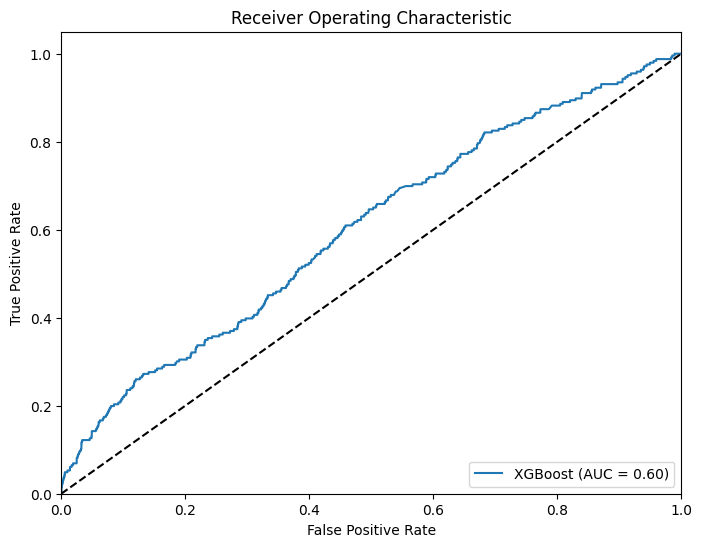

In [2193]:
# compute the AUC score
y_scores = xgb_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [2194]:
# print the recall
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6454
           1       0.11      0.11      0.11       246

    accuracy                           0.94      6700
   macro avg       0.54      0.54      0.54      6700
weighted avg       0.93      0.94      0.94      6700



[[6245  209]
 [ 219   27]]


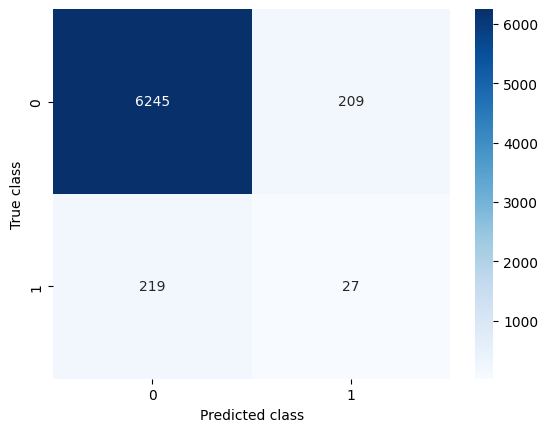

In [2195]:
# compute the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
print(cm)

# plot the confusion matrix
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()


# 2ème approche: BalancedBaggingClassifier

In [2196]:
# load the dataset
df_2 = pd.read_csv('Data_Finance_TrainEtVal_13Nov23.csv', sep=';')

In [2197]:
# fill all Nan values in segmentation with '0'
df_2['segmentation'] = df_2['segmentation'].fillna('0')

zero_percentage = (df_2 == 0).mean() * 100
# print columns where percentage of 0 values is greater than 90%
print(zero_percentage[zero_percentage > 95])

existence impaye regularise    99.584143
presence homonyme              99.956794
montant impayes internes       99.778570
impayes                        99.443724
fichage3                       97.569669
Indicatrice                    96.138475
dtype: float64


In [2198]:
# delete useless columns
df_2.drop(['Id','code naf', 'NO_FOUR', 'code postal', 'date demande', 'presence homonyme', 'montant impayes internes', 'existence impaye regularise', 'impayes', 'fichage3'], axis=1, inplace=True)

df_2.head()

,GENR,produit,age du bien,mode de paiement,montant demande (centimes),delai paiement,apport,apport %,duree,cotation,...,fichage1,dirigeant client,fichage2,charge,revenus,secteur activite,Chiffre d'affaires,Capital social,Indicatrice,Label
0,VP,LLD,0,10,4967310,10,0,0.0,12,X0,...,N,N,N,0,0,77,0,200000,0,Train
1,VP,CB,0,10,1228763,0,245753,20.0,60,X0,...,N,N,N,0,100000,41,0,750000,0,Train
2,VU,CB,0,10,1262250,0,189338,15.0,60,X0,...,N,N,N,0,100000,43,0,500000,0,Train
3,,LLD,0,10,1500000,10,0,0.0,23,X0,...,N,O,N,0,400000,66,0,1000000,0,Train
4,VU,LLD,0,10,2393850,10,0,0.0,36,X0,...,N,N,N,0,300000,49,0,750000,0,Train


## Pretreatment

In [2199]:
# replace N with 0 and O with 1 in columns_2_modif
columns_2_modif = ['alerte fraude', 'Connu', 'fichage', 'incapacite', 'fichage1', 'dirigeant client', 'fichage2']
for col in columns_2_modif:
    df_2[col] = df_2[col].apply(lambda x: 1 if x == 'O' else 0)
    # convert the column to int64
    df_2[col] = df_2[col].astype('int64')

# replace 'ZZZZZZ' value in cotation dirigeant with 0
df_2['cotation dirigeant'] = df_2['cotation dirigeant'].apply(lambda x: 0 if x == 'ZZZZZZ' else x)

# replace ' ' in CSP dirigeant with the most frequent value
df_2['CSP dirigeant'] = df_2['CSP dirigeant'].apply(lambda x: 0 if x == ' ' else x)

# replace ' ' in GENR with the most frequent value
df_2['GENR'] = df_2['GENR'].apply(lambda x: 0 if x == ' ' else x)

In [2200]:
cat_features = df_2.select_dtypes(include=['object']).columns
# remove label 
cat_features = cat_features.drop('Label')
cat_features

Index(['GENR', 'produit', 'cotation', 'segmentation',
       'procédure collective BdF', 'procédure collective ORT', 'contentieux',
       'CSP dirigeant', 'cotation dirigeant', 'secteur activite'],
      dtype='object')

### One hot encoding

In [2201]:
# one hot encode only categorical features in df_2 
df_2 = pd.get_dummies(df_2, columns=cat_features, drop_first=True)

StandardScaler nous permet de centrer et réduire les données.

In [2202]:
# apply standard scaler on all columns of our dataframe but the label and indicatrice
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# remove label and indicatrice
num_features = df_2.select_dtypes(include=['float64', 'int64']).columns
num_features = num_features.drop(['Indicatrice'])
df_2[num_features] = scaler.fit_transform(df_2[num_features])


Splitting the dataset into the Training set and Test set

In [2203]:
X = df_2.drop(['Indicatrice', 'Label'], axis=1)  # Drop the label and the split indicator columns
y = df_2['Indicatrice']  # Labels

# Split the data into training and validation sets
X_train = X[df_2['Label'] == 'Train']
y_train = y[df_2['Label'] == 'Train']

X_test = X[df_2['Label'] == 'Validation']
y_test = y[df_2['Label'] == 'Validation']

In [2204]:
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

xbc = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)

# Créer le modèle BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(estimator=xbc, sampling_strategy='auto', replacement=True, random_state=42)

# Entraîner le modèle
bbc.fit(X_train, y_train)

# Faire des prédictions
y_pred = bbc.predict(X_test)

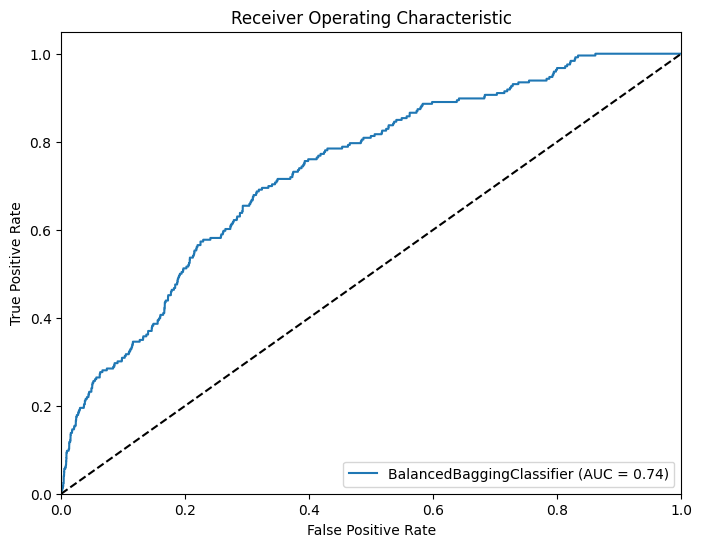

In [2205]:
# compute the AUC score
y_scores = bbc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='BalancedBaggingClassifier (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


              precision    recall  f1-score   support

           0       0.98      0.69      0.81      6466
           1       0.08      0.66      0.14       246

    accuracy                           0.69      6712
   macro avg       0.53      0.68      0.47      6712
weighted avg       0.95      0.69      0.79      6712

[[4485 1981]
 [  83  163]]


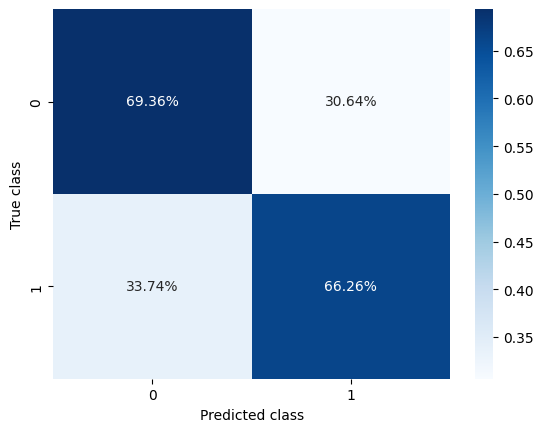

In [2206]:
# print the results
print(classification_report(y_test, y_pred))

# compute the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# plot the confusion matrix
import seaborn as sns
sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()
